# What features contributed to particular predictions


lets see which features contributed to particular predictions

See <a href="https://shap.readthedocs.io/en/latest/index.html">SHAP</a> documentation 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

## Install
see <a href="https://arxiv.org/pdf/2010.06734.pdf"> found that SHAP verse Treeinterpreter</a></strong><mark> found that SHAP took 60x longer than treeinterpreter to complete.</mark>  Concluded that treeinterpreter provided high quality results at a lower computational footprint.<br>
 But... SHAP is activly maintained and treeinterpreter may not be, AND SHAP has its core implemented in C++, so the above paper may no longer be as accurate.
                        

In [2]:
# !conda install -c conda-forge shap -y

# Data

In [3]:
from sklearn.datasets import fetch_california_housing

calif_housing = fetch_california_housing()

for line in calif_housing.DESCR.split("\n"):
    print(line)

calif_housing_df = pd.DataFrame(data=calif_housing.data, columns=calif_housing.feature_names)
calif_housing_df["Price($)"] = calif_housing.target

calif_housing_df.head()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price($)
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
#get train/test split
from sklearn.model_selection import train_test_split
X, y = calif_housing_df.iloc[:,:-1], calif_housing_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2,random_state=123)

# Model- Regression (SHAP also works with classification)

In [5]:
%%time
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=30, random_state=42)
clf.fit(X_train, y_train)

CPU times: user 3 s, sys: 23.7 ms, total: 3.02 s
Wall time: 3.02 s


RandomForestRegressor(n_estimators=30, random_state=42)

In [6]:
from sklearn.metrics import mean_absolute_error
print(f'Models MAE ={mean_absolute_error(clf.predict(X_test),y_test)} on dataset where average price y_test={y_test.mean()}')

Models MAE =0.32761702374031004 on dataset where average price y_test=2.064041664244186


# SHAP
random forests can be turned into a “white box”, such that each prediction is decomposed into a sum of contributions from each feature.<br>
![](./shap.png)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see <a href="https://github.com/slundberg/shap#citations">papers</a> for details and citations).<br>

<mark>One difference between SHAP and treeinterpreter is that SHAP works on any model, not just trees

Lets look at the SHAP values for the first few rows

In [7]:
NUMB_ROWS=100
rows=X_test[:NUMB_ROWS]

#lets see what the first n preds are
preds=clf.predict(rows)
preds

array([1.96603333, 0.93413333, 1.41953333, 1.85456667, 4.12637033,
       2.54383333, 1.3696    , 1.61536667, 2.62993333, 1.52873333,
       1.72563367, 1.9116    , 0.98316667, 3.83156767, 1.40426667,
       2.13036667, 1.64506667, 2.20053267, 0.8342    , 1.7928    ,
       1.527     , 3.346601  , 1.3741    , 0.98553333, 4.15476733,
       4.228201  , 1.83256667, 1.12216667, 0.68896667, 1.90683333,
       0.7879    , 3.24403367, 1.67410033, 3.58560133, 4.87657433,
       1.65343333, 2.58576667, 1.93606667, 1.0744    , 2.0537    ,
       1.0637    , 3.679668  , 1.10326667, 4.87867367, 1.22986667,
       1.8736    , 3.110502  , 3.575668  , 1.9487    , 1.06576667,
       4.23713767, 1.57096667, 2.14053333, 2.4075    , 1.5017    ,
       3.78543567, 1.83      , 3.43506733, 2.42193333, 2.171     ,
       3.452001  , 2.4905    , 1.1254    , 2.2979    , 1.80446667,
       1.855467  , 2.829834  , 2.08983333, 1.09096667, 4.82760767,
       2.81636667, 1.77626667, 1.9825    , 1.39316667, 1.6462 

In [8]:
rows

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
19121,3.7917,40.0,4.959799,1.030151,1039.0,2.610553,38.24,-122.64
20019,4.0217,9.0,5.804577,1.000000,1749.0,3.079225,36.09,-119.05
15104,4.0882,12.0,5.360360,1.070571,3321.0,4.986486,32.85,-116.98
3720,2.2377,27.0,3.376582,1.023207,3403.0,3.589662,34.20,-118.42
8938,4.4211,41.0,5.656904,1.165272,1047.0,2.190377,34.01,-118.47
...,...,...,...,...,...,...,...,...
9828,3.5865,52.0,3.731034,1.082759,240.0,1.655172,36.62,-121.91
6602,2.2326,42.0,4.761468,1.059633,1641.0,3.763761,34.19,-118.16
1144,2.3895,17.0,5.173203,1.081699,730.0,2.385621,39.72,-121.41
18999,5.8269,16.0,7.136986,1.000000,1099.0,3.763699,38.35,-121.95


In [9]:
%%time
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf)
shap_values = explainer(rows)

CPU times: user 6.7 s, sys: 56.8 ms, total: 6.76 s
Wall time: 6.76 s


In [10]:
#the shap values for row 0, 
#values SHAPly values, or how much each feature contributed to prediicted result, or pred = shap_values.base_value + sum(shap_values.values)
#base value is average prediction on entire training set
# data= original row values
shap_values[0]

.values =
array([-0.10132017,  0.01481928, -0.08931269, -0.01193649, -0.02065155,
       -0.0502882 , -0.4528497 ,  0.60887465])

.base_values =
2.068698214389535

.data =
array([ 3.79170000e+00,  4.00000000e+01,  4.95979899e+00,  1.03015075e+00,
        1.03900000e+03,  2.61055276e+00,  3.82400000e+01, -1.22640000e+02])

In [11]:
explainer.expected_value

array([2.06869821])

Model predicts 1.966 for row 0, average prediction for training set=2.069


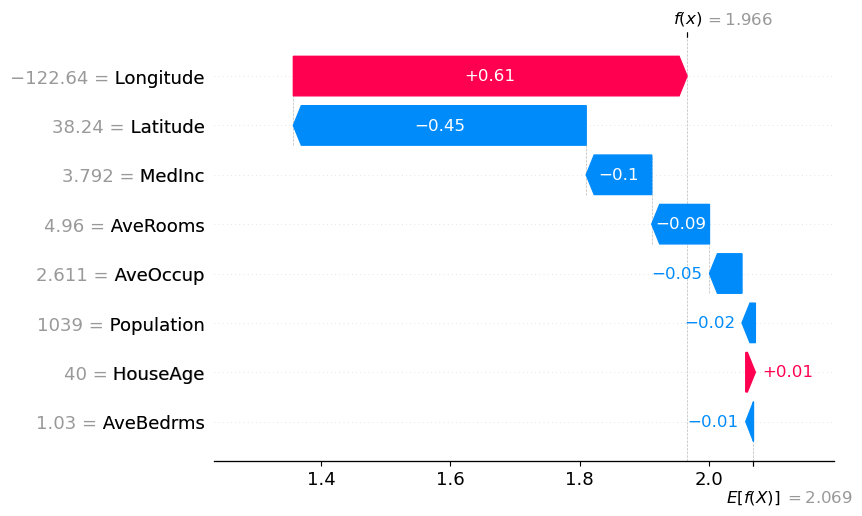

In [12]:
#see the shap effects on first prediction
print(f'Model predicts {preds[0]:.3f} for row 0, average prediction for training set={explainer.expected_value[0]:.3f}')
shap.plots.waterfall(shap_values[0]) #plots the waterfall for the ith observation

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot

### What is E[f(x)]? It is the average prediction of your model on the entire X_train dataset (used as a baseline value by SHAP).

NOTE: see <a href="https://github.com/slundberg/shap/issues/318#issuecomment-437429986">shap explainer expected_value is different from model expected value:</a> for explanation of why this number differes slightly from SHAPs expected_value when using Random Forest.

Start from this value and determine what effect, positive or negative, each feature adds.

In [13]:
#this is the average of all predictions on X_train
preds_all=clf.predict(X_train)
np.average(preds_all)

2.0745785765907625

In [14]:
#this is SHAPs average, it is gleaned from the trees of the forest itself, each of which SAMPLED X_train.  So it's slightly different from above average
explainer.expected_value

array([2.06869821])

## A compact way to show above

In [15]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

## Lets show force plots for all NUMB_ROWS rows

Takes force plots for each row, rotates 90 degrees and then plots them all

In [16]:
# visualize all the training set predictions
shap.plots.force(shap_values[:NUMB_ROWS])

## What about if you want to see the effects that each feature has on many rows?

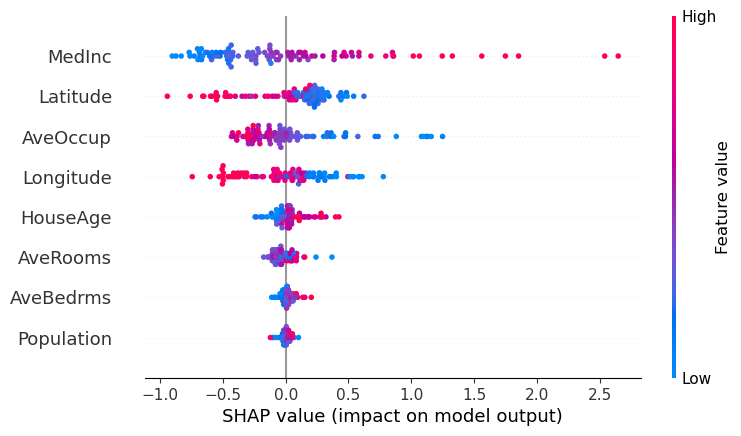

In [18]:
#which features are most important?  Plot all the SHAP values to see how they affect price
#Higher MedInc adds to the price
#Higher Latitude subtracts from the price the price
#Population (at least for this sample) has litlle effect other than the few outliers that indicate that lower population adds to the price
shap.plots.beeswarm(shap_values)

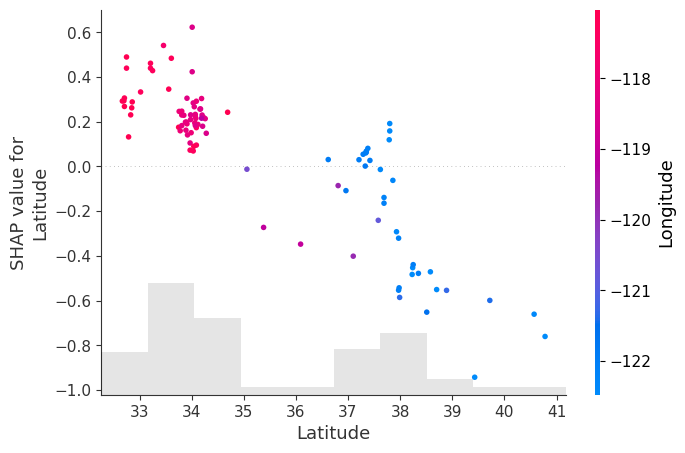

In [21]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
#this shows that lower lattitudes correspond to higher prices
shap.plots.scatter(shap_values[:, "Latitude"], color=shap_values)

## What are the most important features?

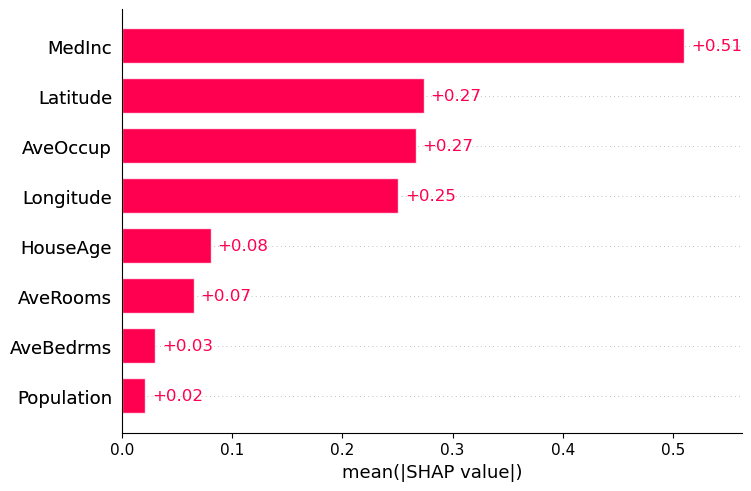

In [22]:
shap.plots.bar(shap_values)